## Function 2

Optimising Noisy Models
This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

1. Load the provided initial data.
2. Visualize the current data to understand its structure.
3. Fit a Gaussian Process (GP) surrogate model.
4. Use Bayesian optimization to suggest the next best point(s).

Noticing peaks along a line at 7 on the 1st axis - exploring there

In [1]:
# update data weekly
import numpy as np
import os

# Function number (update this as needed)
function_id = 2  # change for f2, f3, etc.

# Load original data
inputs_path = f'function_{function_id}/initial_inputs.npy'
outputs_path = f'function_{function_id}/initial_outputs.npy'
inputs = np.load(inputs_path)
outputs = np.load(outputs_path)

# Load new data (replace this with your actual new submissions)
# Example: new 2D point with corresponding output
# week1: 0.802637	0.0841	0.014444307
# week2: 0.76583285	0.22074749	0.131936896
# week3_1t 0.83538592	0.9265642	and 0.145698279889226
# week3_2f 0.599152	0.470055	and 0.038821901
# w4-1t: 0.877791	0.028698	and 0.119877869
# w4-2f: 0.621650	0.123010	and 0.173992824
# w5-1t: 0.777131	0.877131	and 0.164935416
# w5-2f: 0.602636	0.916564	and 0.0903606511651409
# w6-1t: 0.748742	0.609720 and 0.418260586470547
# w6-2f: 0.241750	0.926564 and -0.00681532508292488
# w7-1t: 0.715833	0.795833 and 0.584575884357487
# w7-2f: 0.695542	0.655210 and 0.548743963541445
# w8-1t: 0.705833	0.509720 and 0.638062578656126
# w8-2f: 0.715833	0.295833 and 0.575745022022471
# w9-1t: 0.705833	0.385055 and 0.480639807699096
# W9-2f: 0.705833	0.103010 and 0.597407775079536
# w10-1t: 0.705900	0.197049 and 0.690117274311009
# w10-2f: 0.701651	0.450899 and 0.620676319822228

new_inputs = np.array([[0.701651, 0.450899]])
new_outputs = np.array([0.620676319822228])

# Concatenate new data to existing
updated_inputs = np.vstack([inputs, new_inputs])
updated_outputs = np.concatenate([outputs, new_outputs])
print("updated_inputs shape:", updated_inputs.shape)
print("updated_outputs shape:", updated_outputs.shape)
# Optionally: save backup copies before overwriting
np.save(f'function_{function_id}/backup_inputs.npy', inputs)
np.save(f'function_{function_id}/backup_outputs.npy', outputs)

# Save updated files
np.save(inputs_path, updated_inputs)
np.save(outputs_path, updated_outputs)

print("Updated data saved.")

updated_inputs shape: (28, 2)
updated_outputs shape: (28,)
Updated data saved.


inputs_f2 shape: (28, 2)
outputs_f2 shape: (28,)
Threshold: 0.5430023632706773


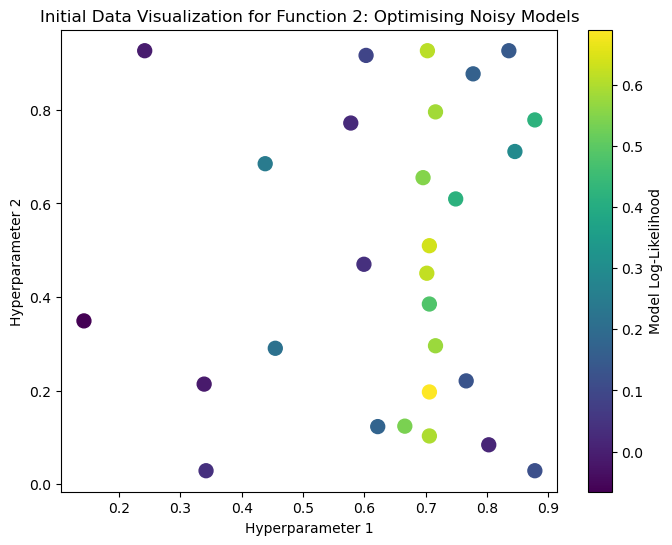

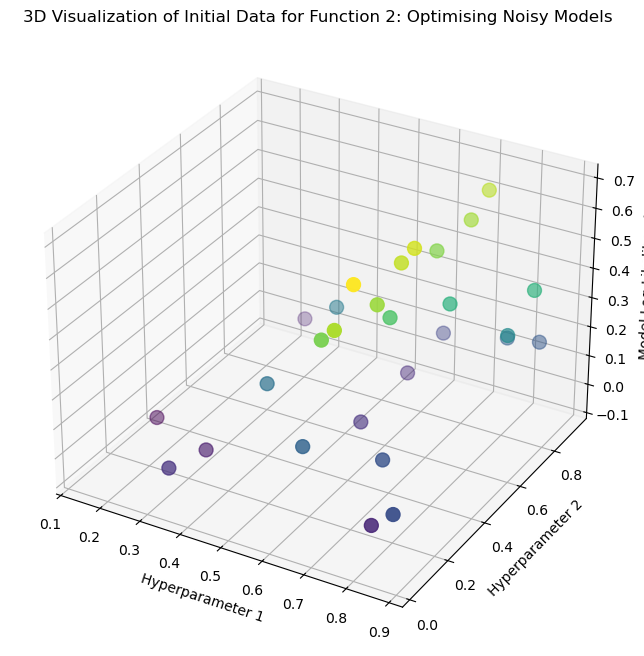

Suggested next best input point: [0.72625167 0.48041849]
Suggested next best input (6 decimals): ['0.726252', '0.480418']


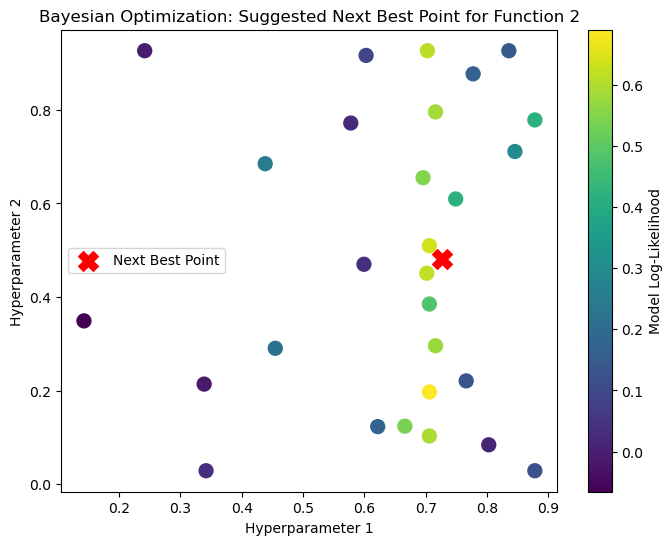

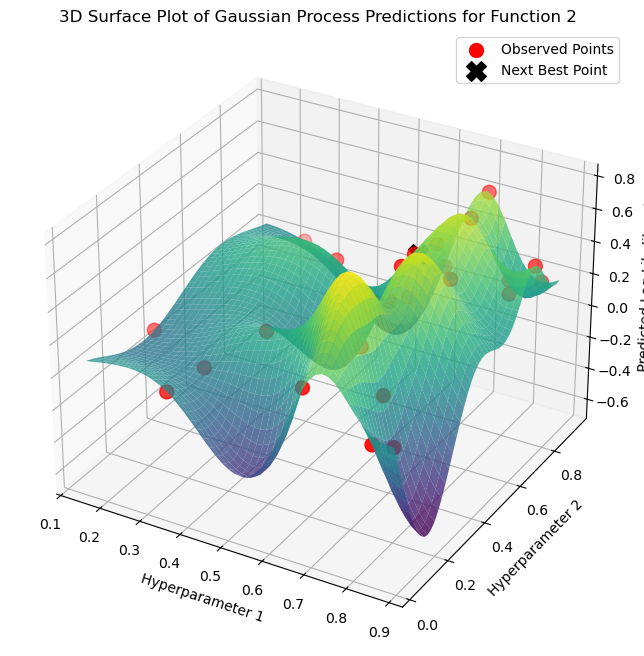

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# Load initial data
inputs_f2 = np.load('function_2/initial_inputs.npy')
outputs_f2 = np.load('function_2/initial_outputs.npy')
print("inputs_f2 shape:", inputs_f2.shape)
print("outputs_f2 shape:", outputs_f2.shape)
# # Count negative outputs
# num_negative = np.sum(outputs_f2 < 0)
    
# # Check if negative outputs constitute the majority
# if num_negative > len(outputs_f2) / 2:
#    # print(f"Majority are negative: {num_negative}/{len(outputs)}")
#    outputs_f2 = -outputs_f2

# Calculate threshold using Mean plus one standard deviation
threshold = outputs_f2.mean() + outputs_f2.std()
print("Threshold: "+str(threshold))
# Step 1: Visualize initial data (2D scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f2[:, 0], inputs_f2[:, 1], c=outputs_f2, cmap='viridis', s=100)
plt.colorbar(label='Model Log-Likelihood')
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Initial Data Visualization for Function 2: Optimising Noisy Models')
plt.show()

# Step 2: Visualize initial data (3D scatter plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inputs_f2[:, 0], inputs_f2[:, 1], outputs_f2, c=outputs_f2, cmap='viridis', s=100)
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Model Log-Likelihood')
ax.set_title('3D Visualization of Initial Data for Function 2: Optimising Noisy Models')
plt.show()

# Step 3: Define the function to suggest next best point using Bayesian Optimization within a radius
def suggest_next_point(inputs, outputs, threshold, radius=0.3):
    def gp_predict(x, gp):
        return -gp.predict(x.reshape(1, -1))[0]

    # Fit Gaussian Process surrogate model
    gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), n_restarts_optimizer=10)
    gp.fit(inputs, outputs)

    # Find points with elevated log-likelihood
    elevated_points = inputs[outputs > threshold]

    # Define optimization bounds near elevated points
    if elevated_points.size > 0:
        min_bounds = np.maximum(np.min(elevated_points, axis=0) - radius, np.min(inputs, axis=0))
        max_bounds = np.minimum(np.max(elevated_points, axis=0) + radius, np.max(inputs, axis=0))
    else:
        min_bounds = np.min(inputs, axis=0)
        max_bounds = np.max(inputs, axis=0)

    bounds = [(min_bounds[i], max_bounds[i]) for i in range(inputs.shape[1])]

    # Optimize to find the next best query point
    result = minimize(gp_predict, np.mean(elevated_points, axis=0) if elevated_points.size > 0 else np.mean(inputs, axis=0), args=(gp,), bounds=bounds)
    return result.x, gp

# Step 4: Suggest the next best input location
next_best_point, gp_model = suggest_next_point(inputs_f2, outputs_f2, threshold)
print(f"Suggested next best input point: {next_best_point}")
print("Suggested next best input (6 decimals):", [f"{x:.6f}" for x in next_best_point])


# Visualize the suggested next best point
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f2[:, 0], inputs_f2[:, 1], c=outputs_f2, cmap='viridis', s=100)
plt.colorbar(label='Model Log-Likelihood')
plt.scatter(next_best_point[0], next_best_point[1], color='red', marker='X', s=200, label='Next Best Point')
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Bayesian Optimization: Suggested Next Best Point for Function 2')
plt.legend()
plt.show()

# Step 5: Visualize a 3D surface plot of the Gaussian Process predictions
x = np.linspace(np.min(inputs_f2[:, 0]), np.max(inputs_f2[:, 0]), 50)
y = np.linspace(np.min(inputs_f2[:, 1]), np.max(inputs_f2[:, 1]), 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T
Z = gp_model.predict(XY).reshape(X.shape)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(inputs_f2[:, 0], inputs_f2[:, 1], outputs_f2, color='red', s=100, label='Observed Points')
ax.scatter(next_best_point[0], next_best_point[1], gp_model.predict(next_best_point.reshape(1, -1)), color='black', marker='X', s=200, label='Next Best Point')
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Predicted Log-Likelihood')
ax.set_title('3D Surface Plot of Gaussian Process Predictions for Function 2')
plt.legend()
plt.show()

🧠 Key Implications from the Clue:
High noise in the observations:

The outputs you're optimizing (log-likelihoods) vary a lot, even for the same inputs.

The GP model should explicitly account for noise (heteroscedasticity if possible, but at minimum a alpha noise parameter).

Many local optima:

The surrogate model must allow flexibility in shape, which your Matern kernel does well.

The acquisition function must balance exploration/exploitation carefully — UCB is good, but Thompson Sampling or Batch EI might give better robustness.

✅ Recommended Adaptations to Your Code:
🔧 1. Model the Noise:
Add alpha=some small value to the GP constructor. You can tune this based on estimated noise variance, or set a fixed one (e.g., alpha=1e-3).
gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)

🔁 2. Repeat Observations (Data Augmentation):
If possible in practice, query the same point multiple times to estimate variance. For now, simulate this via sampling or clustering.

📈 3. Use a More Exploratory Acquisition Strategy:
You're already using UCB, which is good for noisy problems. You might also consider:

Thompson Sampling (as you used in Function 1) to randomly sample from GP posterior

Expected Improvement with noise correction (e.g. via noisy EI)

🆕 Optional: Visualize GP uncertainty

inputs_f2 shape: (28, 2)
outputs_f2 shape: (28,)


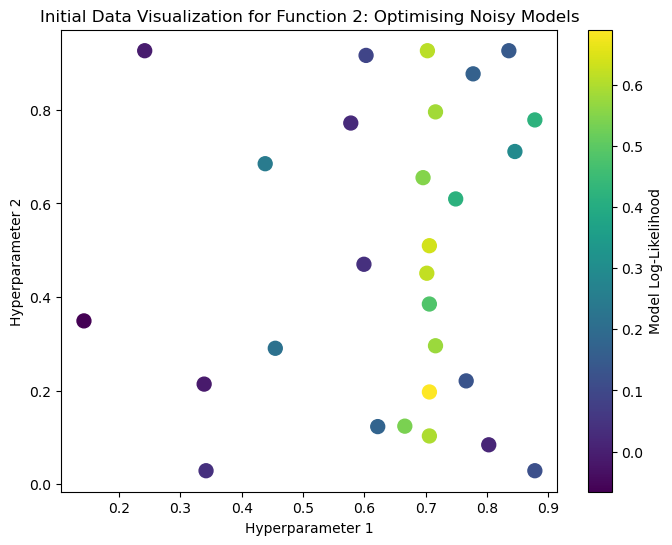

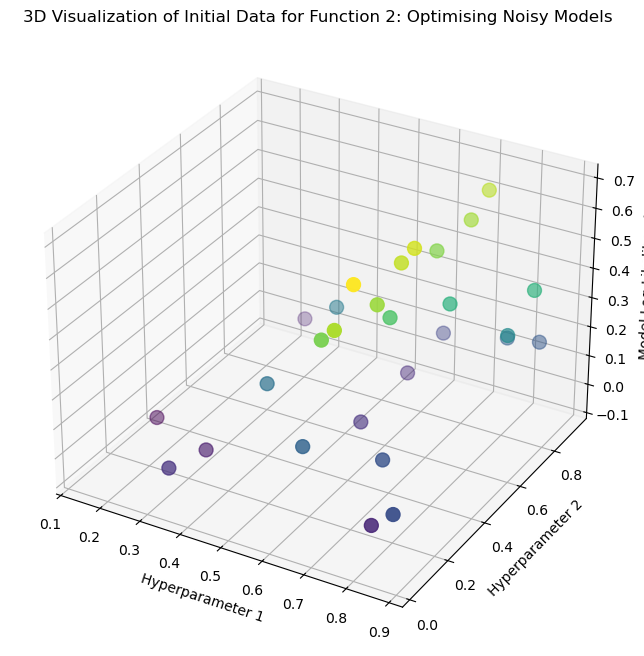

Suggested next best input point: [0.68136333 0.5736162 ]
GaussianProcessRegressor(alpha=0.01, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True)


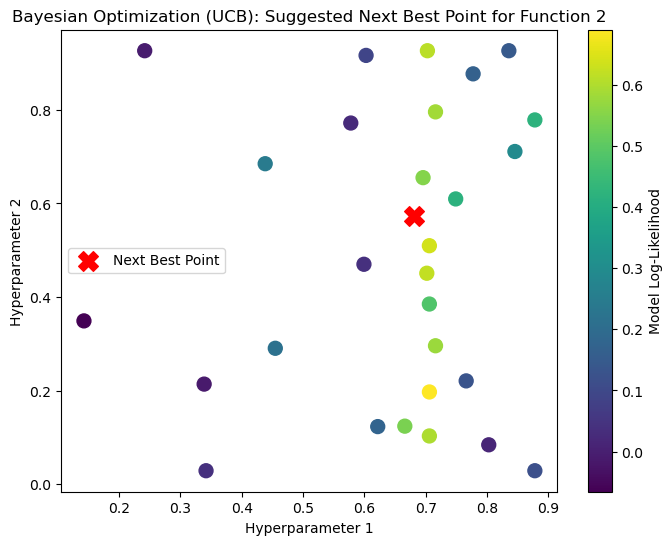

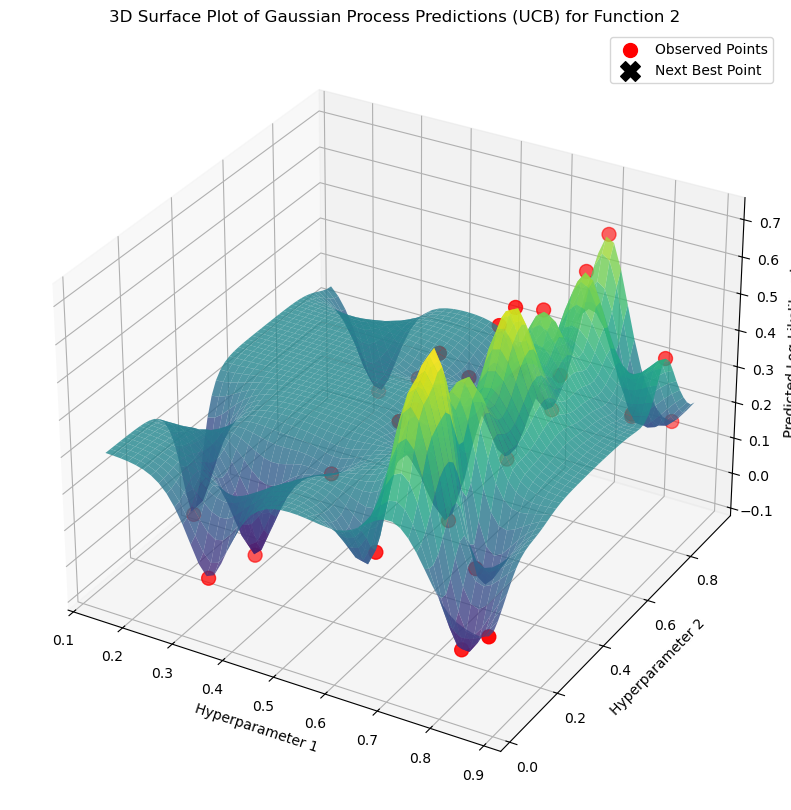

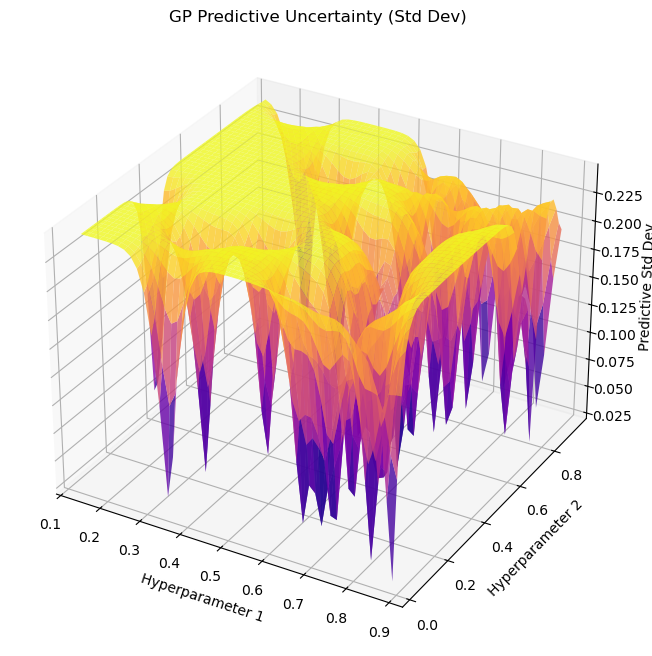

In [5]:
# Import necessary libraries
#  USED FOR WEEK2 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# Load initial data
inputs_f2 = np.load('function_2/initial_inputs.npy')
outputs_f2 = np.load('function_2/initial_outputs.npy')
print("inputs_f2 shape:", inputs_f2.shape)
print("outputs_f2 shape:", outputs_f2.shape)


# Check if negative outputs constitute the majority and invert if necessary
num_negative = np.sum(outputs_f2 < 0)
if num_negative > len(outputs_f2) / 2:
    outputs_f2 = -outputs_f2

# Step 1: Visualize initial data (2D scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f2[:, 0], inputs_f2[:, 1], c=outputs_f2, cmap='viridis', s=100)
plt.colorbar(label='Model Log-Likelihood')
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Initial Data Visualization for Function 2: Optimising Noisy Models')
plt.show()

# Step 2: Visualize initial data (3D scatter plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inputs_f2[:, 0], inputs_f2[:, 1], outputs_f2, c=outputs_f2, cmap='viridis', s=100)
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Model Log-Likelihood')
ax.set_title('3D Visualization of Initial Data for Function 2: Optimising Noisy Models')
plt.show()

# Step 3: Bayesian Optimization using Upper Confidence Bound (UCB)
def suggest_next_point_ucb(inputs, outputs, kappa=2.575):  # kappa to favour exploration 
    gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-2, n_restarts_optimizer=10, normalize_y=True)
    gp.fit(inputs, outputs)

    def ucb(x):
        mean, std = gp.predict(x.reshape(1, -1), return_std=True)
        return -(mean + kappa * std)  # Maximize mean + uncertainty

    bounds = [(np.min(inputs[:, i]), np.max(inputs[:, i])) for i in range(inputs.shape[1])]
    result = minimize(ucb, np.mean(inputs, axis=0), bounds=bounds)
    return result.x, gp

# Step 4: Suggest the next best input location
next_best_point, gp_model = suggest_next_point_ucb(inputs_f2, outputs_f2)
print(f"Suggested next best input point: {next_best_point}")
print(gp_model)

# Visualize the suggested next best point
plt.figure(figsize=(8, 6))
plt.scatter(inputs_f2[:, 0], inputs_f2[:, 1], c=outputs_f2, cmap='viridis', s=100)
plt.colorbar(label='Model Log-Likelihood')
plt.scatter(next_best_point[0], next_best_point[1], color='red', marker='X', s=200, label='Next Best Point')
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title('Bayesian Optimization (UCB): Suggested Next Best Point for Function 2')
plt.legend()
plt.show()

# Step 5: Visualize a 3D surface plot of the Gaussian Process predictions
x = np.linspace(np.min(inputs_f2[:, 0]), np.max(inputs_f2[:, 0]), 50)
y = np.linspace(np.min(inputs_f2[:, 1]), np.max(inputs_f2[:, 1]), 50)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T
Z = gp_model.predict(XY).reshape(X.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.scatter(inputs_f2[:, 0], inputs_f2[:, 1], outputs_f2, color='red', s=100, label='Observed Points')
ax.scatter(next_best_point[0], next_best_point[1], gp_model.predict(next_best_point.reshape(1, -1)), color='black', marker='X', s=200, label='Next Best Point')
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Predicted Log-Likelihood')
ax.set_title('3D Surface Plot of Gaussian Process Predictions (UCB) for Function 2')
plt.legend()
plt.show()

Z_mean, Z_std = gp_model.predict(XY, return_std=True)
Z_std = Z_std.reshape(X.shape)

# Plot predictive uncertainty surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_std, cmap='plasma', alpha=0.8)
ax.set_title('GP Predictive Uncertainty (Std Dev)')
ax.set_xlabel('Hyperparameter 1')
ax.set_ylabel('Hyperparameter 2')
ax.set_zlabel('Predictive Std Dev')
plt.show()